In [1]:
!pip install split-folders

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders  # or import split_folders

import tensorflow as tf
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Add
from keras.layers import Lambda, GlobalMaxPooling2D, Concatenate, Dropout
from keras.models import Model
from keras.layers import Input, Multiply
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-10-16 19:14:20.945322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 19:14:20.945450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 19:14:21.091568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
splitfolders.ratio('/kaggle/input/datasetss/Tomato', output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values





Copying files: 3801 files [00:15, 247.97 files/s]


In [3]:
# Définir le générateur d'images pour l'entraînement
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  
#                                  rotation_range=40,
#                                  width_shift_range=0.2,
#                                  height_shift_range=0.2,
#                                  shear_range=0.2,
#                                  zoom_range=0.2,
#                                  horizontal_flip=True,
#                                  vertical_flip=True,
#                                  featurewise_std_normalization=True,
#                                  fill_mode='nearest'      # Remplissage des pixels vides après transformation
)

# Créer le dataset d'entraînement
train_dataset = train_datagen.flow_from_directory('./output/train',
                                                  target_size=(256,256),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 3040 images belonging to 4 classes.


In [4]:

# Générateur d'images pour la validation (sans augmentation)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,  
#                                rotation_range=40,
#                                width_shift_range=0.2,
#                                height_shift_range=0.2,
#                                shear_range=0.2,
#                                zoom_range=0.2,
#                                horizontal_flip=True,
#                                vertical_flip=True,
#                                featurewise_std_normalization=True,
#                                fill_mode='nearest'
) 



# Créer le dataset de validation
val_dataset = val_datagen.flow_from_directory('./output/val',
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True
)

Found 761 images belonging to 4 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Activation, Multiply, Add, Reshape, Conv2D, Lambda, Concatenate, BatchNormalization)

def cbam_block(inputs, ratio=8):
    channel = inputs.shape[-1]
    
    # Channel Attention Module
    # Global Average Pooling
    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Dense(channel // ratio, use_bias=False)(avg_pool)
    avg_pool = BatchNormalization()(avg_pool)
    avg_pool = Activation('swish')(avg_pool)
    avg_pool = Dense(channel, use_bias=False)(avg_pool)
    avg_pool = Activation('sigmoid')(avg_pool)
    
    # Global Max Pooling
    max_pool = GlobalMaxPooling2D()(inputs)
    max_pool = Dense(channel // ratio, use_bias=False)(max_pool)
    max_pool = BatchNormalization()(max_pool)
    max_pool = Activation('swish')(max_pool)
    max_pool = Dense(channel, use_bias=False)(max_pool)
    max_pool = Activation('sigmoid')(max_pool)
    
    # Combining Channel Attention Features
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)
    
    # Apply Channel Attention
    channel_refined = Multiply()([inputs, cbam_feature])
    
    # Spatial Attention Module
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat_spatial = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    
    # Convolution for Spatial Attention
    spatial_attention = Conv2D(filters=1, kernel_size=7, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False)(concat_spatial)
    spatial_attention = BatchNormalization()(spatial_attention)
    spatial_attention = Activation('sigmoid')(spatial_attention)
    
    # Apply Spatial Attention
    refined_output = Multiply()([channel_refined, spatial_attention])
    
    return refined_output


In [23]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
# Load ResNet50 model pre-trained on ImageNet
input_tensor = Input(shape=(256, 256, 3))

# Preprocess the input using the preprocessing function
preprocessed_input = preprocess_input(input_tensor)

# Load the ResNet50 base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=shap)
resnet_base.trainable=False
x = resnet_base(preprocessed_input, training=True)
# Apply CBAM block
x = cbam_block(x)
x = GlobalAveragePooling2D()(x)
# Dense layers with regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = Dense(, activation='softmax')(x)
# Global Average Pooling
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Dropout(0.5)(x)  # Use dropout to reduce overfitting
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)


# Output layer with softmax activation for classification


# Create the final model
model = Model(inputs=input_tensor, outputs=outputs)

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Summary of the model
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 256, 256)  │          0 │ input_layer_4[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 256, 256,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256, 256,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    524,288 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │    524,288 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 2048)      │    524,288 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 2048)      │    524,288 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 2048)      │          0 │ dense_16[0][0]  

 Total params: 28,312,042 (108.00 MB)

 Trainable params: 4,723,304 (18.02 MB)

 Non-trainable params: 23,588,738 (89.98 MB)

In [26]:
# Assuming you have your dataset ready (train_dataset, val_dataset)
# Replace `train_dataset` and `val_dataset` with your actual data generators or datasets

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-5)

# Add this callback when fitting your model
my_model = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[reduce_lr]
)


Epoch 1/10
 1/95 ━━━━━━━━━━━━━━━━━━━━ 24:06 15s/step - accuracy: 0.1250 - loss: 3.4416

W0000 00:00:1729108372.598643     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729108372.599366     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7649 - loss: 1.9636

W0000 00:00:1729108386.456578     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729108386.457210     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.7662 - loss: 1.9559 - val_accuracy: 0.8896 - val_loss: 0.7283 - learning_rate: 0.0010
Epoch 2/10


W0000 00:00:1729108390.820033     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729108390.820542     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9822 - loss: 0.4320 - val_accuracy: 0.9566 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9872 - loss: 0.2464 - val_accuracy: 0.9790 - val_loss: 0.1967 - learning_rate: 0.0010
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.9896 - loss: 0.1641 - val_accuracy: 0.9632 - val_loss: 0.1980 - learning_rate: 0.0010
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9931 - loss: 0.1261 - val_accuracy: 0.9790 - val_loss: 0.1315 - learning_rate: 0.0010
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.9953 - loss: 0.0972 - val_accuracy: 0.9777 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9958 - loss: 0.0664 - val_accuracy: 0.9882 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9968 - loss: 0.0548 - val_

In [27]:
test_loss, test_accuracy = model.evaluate(val_dataset)  # Utilisez val_dataset ou test_dataset si vous en avez un

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9938 - loss: 0.0549


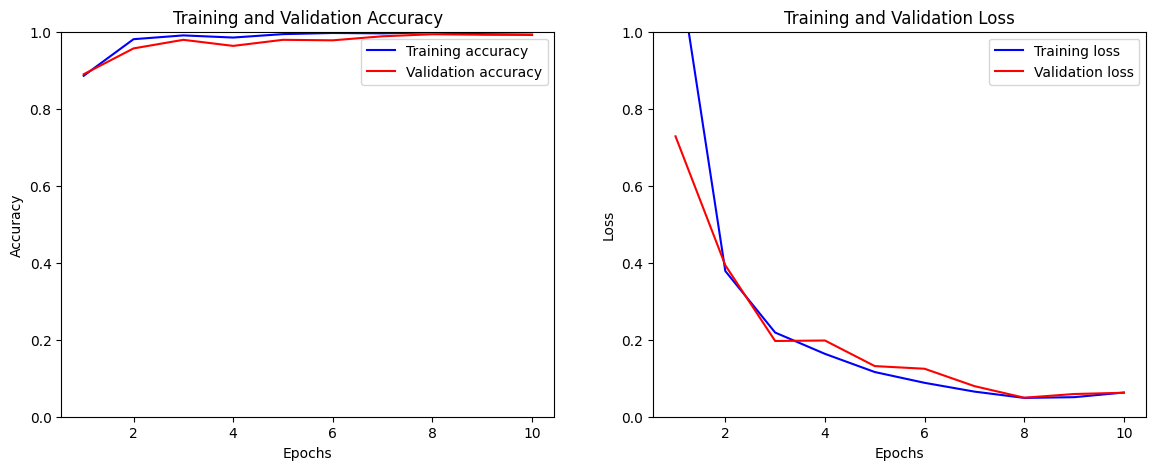

In [28]:
import matplotlib.pyplot as plt

# Extraction des données d'accuracy et de loss
train_accuracy = my_model.history['accuracy']
val_accuracy = my_model.history['val_accuracy']
train_loss = my_model.history['loss']
val_loss = my_model.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

# Plot de l'accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0,1)

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1)


plt.show()

In [29]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# class_names = list(train_dataset.class_indices.keys())
# #print("Class Names:", class_names)

# # Lire l'image depuis un fichier
# img_path = "/kaggle/input/datasetss/tomato_state/Tomato___healthy/148e32de-8876-45d9-92c5-43c17d7292fa___RS_HL 0189_final_masked.jpg"
# image = cv2.imread(img_path)

# # Convertir l'image de BGR (format par défaut d'OpenCV) en RGB
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Afficher l'image en utilisant Matplotlib
# plt.imshow(image_rgb)
# plt.axis('off')  # Masquer les axes
# plt.show()


# img = load_img(img_path, target_size=(256, 256))
# img_array = img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch

# # Make a prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions[0])

# # Get the predicted class name
# predicted_class_name = class_names[predicted_class_index]
# #print(predictions)
# #print('Predicted class index:', predicted_class_index)
# print('Predicted class name:', predicted_class_name)
# if predicted_class_name == 'Tomato___healthy':
#     print('plant is healthy, no need to do treatment')
# else:
#     print('plant is diseased , it needs treatment')

 2/24 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step

W0000 00:00:1729108519.184492     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729108519.185262     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step


W0000 00:00:1729108525.252088     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729108525.252678     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


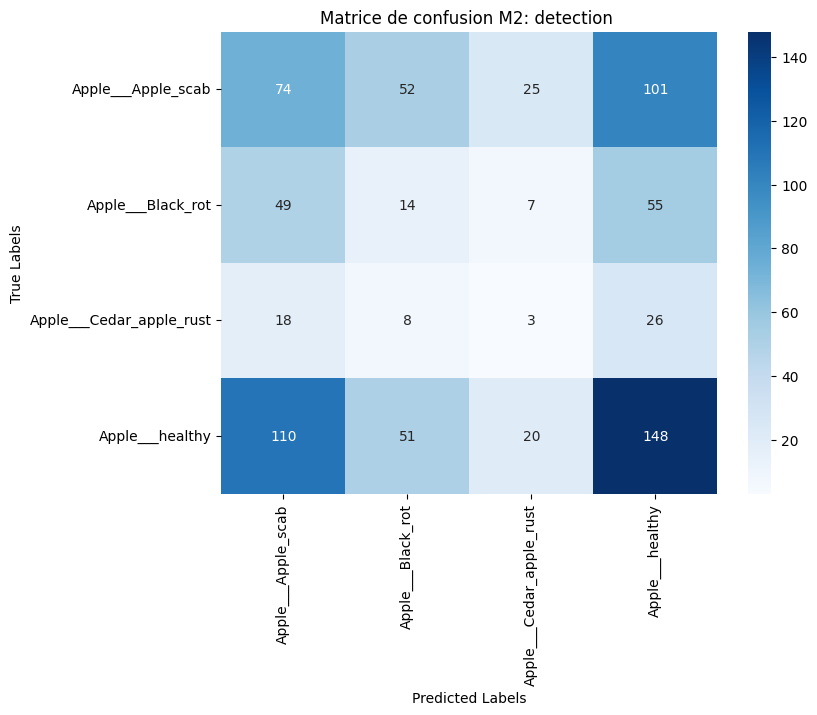

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Make predictions
# Predict class probabilities for the validation set
val_predictions = model.predict(val_dataset)

# Step 2: Convert predictions to class labels
# Get the class with the highest probability for each prediction
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Step 3: Get true labels from the validation generator
# Since val_generator.classes gives the true labels of the validation data
val_true_classes = val_dataset.classes

# Step 4: Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_predicted_classes)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.class_indices.keys(), yticklabels=val_dataset.class_indices.keys())
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Matrice de confusion M2: detection ')
plt.show()